# City Council Presentation Figures

This notebook is written to generate the figures to be used in my presentation on the local links between wildfire smoke and labor profits to Clovis, NM's city council. The notebook is meant to take in processed data files in CSV formats, and then use them to generate and output the figures that will be included in the presentation (to the "visualizations" folder specifically).


In [21]:
#This defines all of the packages and constants (which, in this case, represent file paths) to be used in the notebook

import os, json, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


common_analysis_data_folder =  "common_analysis_data/"
processed_input_data_folder =  "processed_input_data/"
output_folder = "visualizations/"

## Section 1 - Introduction to Data Figures

The below three figures are meant to be used to introduce the audience to the datasets used in the presentation, and show what they each look like in isolation when localized for Clovis

In [22]:
#This cell imports the three CSVs and combines them into one dataset


processed_wf_data = pd.concat([pd.read_csv(common_analysis_data_folder + "first_chunk_df.csv"),
                              pd.read_csv(common_analysis_data_folder + "second_chunk_df.csv"),
                              pd.read_csv(common_analysis_data_folder + "third_chunk_df.csv")],
                              ignore_index = True)

wf_in_range = processed_wf_data[processed_wf_data.shortest_distance_dist <= 1250]

In [23]:
#this cell uses the USGS dataset to create a dataframe of all wildfires in the U.S. (since 1963)
group_by_year = processed_wf_data.groupby('year')['index'].count()
group_by_year = pd.DataFrame({
    "year": list(group_by_year.index),
    "number_of_wildfires": list(group_by_year)
})

In [24]:
#this cell uses the USGS dataset to create a dataframe of all wildfires within 1250 miles of Clovis (since 1963)
in_range_by_year = wf_in_range.groupby('year')['index'].count()
in_range_by_year = pd.DataFrame({
    "year": list(in_range_by_year.index),
    "number_of_wildfires": list(in_range_by_year)
})

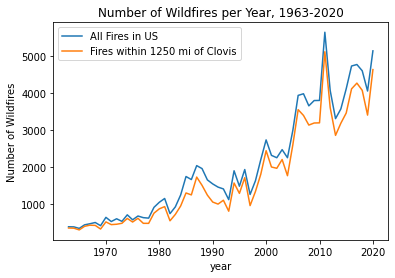

In [25]:
#This viz shows how wildfires occurred both within 1250 of Clover and in all of the US.

plt.plot(group_by_year['year'], group_by_year['number_of_wildfires'], label="All Fires in US")
plt.plot(in_range_by_year['year'], in_range_by_year['number_of_wildfires'], label="Fires within 1250 mi of Clovis")
plt.xlabel('year')
plt.ylabel('Number of Wildfires')
plt.title('Number of Wildfires per Year, 1963-2020')
plt.legend()
plt.savefig(output_folder + 'wildfires_per_year_nationwide.png', facecolor='white', transparent=False )
plt.show()

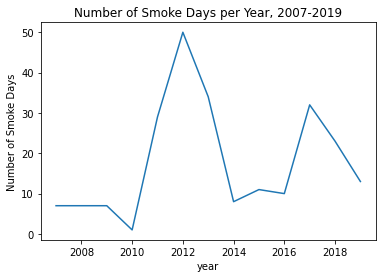

In [26]:
#This viz shows how many smoke days Clovis had each year between 2007 and 2019

smoke_day_dataset = pd.read_csv(processed_input_data_folder + "curry_NM_hms_data.csv")

smoke_days_per_year = smoke_day_dataset.groupby('rfrnc_yr')['num_smoke_days'].sum()
smoke_days_per_year = pd.DataFrame({
    "year": list(smoke_days_per_year.index),
    "smoke_days": list(smoke_days_per_year)
})

plt.plot(smoke_days_per_year['year'], smoke_days_per_year['smoke_days'])
plt.xlabel('year')
plt.ylabel('Number of Smoke Days')
plt.title('Number of Smoke Days per Year, 2007-2019')
plt.savefig(output_folder + '/smoke_days_per_year.png', facecolor='white', transparent=False)
plt.show()

In [27]:
#this cell takes in the QWI dataset for Curry county and converts it into a dataframe
#showing the totals for each year
curry_qwi_county_quarterly = pd.read_csv(processed_input_data_folder + "curry_qwi_county_quarterly.csv")

payroll_per_year = curry_qwi_county_quarterly.groupby('rfrnc_yr')['qwi_payroll'].sum()
payroll_per_year = pd.DataFrame({
    "year": list(payroll_per_year.index),
    "total_payroll": list(payroll_per_year)
})

payroll_per_year = payroll_per_year[payroll_per_year['year'] > 1995]
payroll_per_year = payroll_per_year[payroll_per_year['year'] < 2020]

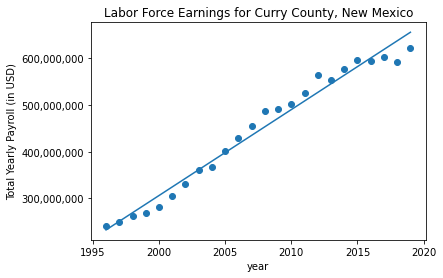

In [28]:
#This cell generates a scattershot of the QWI dataset for Curry, and adds a best-fit line.
#This shows that Curry's labor profits are generally see an upward trend, even though
#some years see more/less growth than on average 

plt.scatter(payroll_per_year['year'], payroll_per_year['total_payroll'])

z = np.polyfit(payroll_per_year['year'], payroll_per_year['total_payroll'], 1)
p = np.poly1d(z)
plt.plot(payroll_per_year['year'], p(payroll_per_year['year']))

plt.title('Labor Force Earnings for Curry County, New Mexico')
plt.xlabel('year')
plt.ylabel('Total Yearly Payroll (in USD)')
plt.gcf().axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
plt.savefig(output_folder + '/payroll_per_year_best_fit_line.png', bbox_inches="tight", facecolor='white', transparent=False)
plt.show()

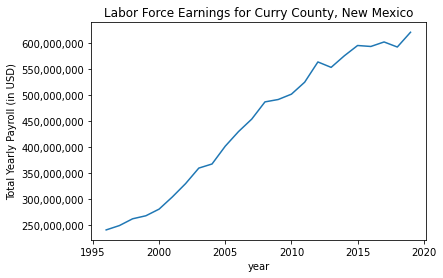

In [29]:
#This cell generates a time series graph of the QWI data for Clovis

plt.plot(payroll_per_year['year'], payroll_per_year['total_payroll'])

plt.title('Labor Force Earnings for Curry County, New Mexico')
plt.xlabel('year')
plt.ylabel('Total Yearly Payroll (in USD)')
plt.gcf().axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
plt.savefig(output_folder + '/payroll_per_year_time_series.png', bbox_inches="tight", facecolor='white', transparent=False)
plt.show()

## Section 2 - Overall QWI vs. Wildfire Smoke

The following cells take the yearly QWI data for Curry county and plot them with the number of smoke days and number of in-range (within 1250 miles) wildfires for Clovis for their corresponding year. These graphs are meant to examine whether a general relationship can be identified right off the bat.

In [30]:
#This cell and the one below create a dataframe containing how much labor profits
#increased for Clovis compared to the previous year, and then adds the two wildfire/smoke
#statistics (number of in-range wildfires and number of smoke days for those years), so
#that they can be graphed together.

payroll_rate_of_change = payroll_per_year
payroll_rate_of_change['last_year_payroll'] = payroll_per_year['total_payroll'].shift(1)
payroll_rate_of_change['payroll_increase'] = payroll_rate_of_change['total_payroll'] - payroll_rate_of_change['last_year_payroll']


In [31]:
changeRates_after_2007 = pd.DataFrame(payroll_rate_of_change[payroll_rate_of_change['year'] > 2006])
changeRates_after_2007.reset_index(inplace = True)


numWF_after_2007 = pd.DataFrame(group_by_year[group_by_year['year'] > 2006])
numWF_after_2007 = pd.DataFrame(numWF_after_2007[numWF_after_2007['year'] < 2020])
numWF_after_2007.reset_index(inplace = True)

smoke_days_vs_trendline_changeRates = pd.DataFrame({
    "year": smoke_days_per_year['year'],
    "smoke_days": smoke_days_per_year['smoke_days'],
    "num_WF": numWF_after_2007['number_of_wildfires'],
    "payroll": changeRates_after_2007['total_payroll'],
    "rate_of_change_pr": changeRates_after_2007['payroll_increase']

})


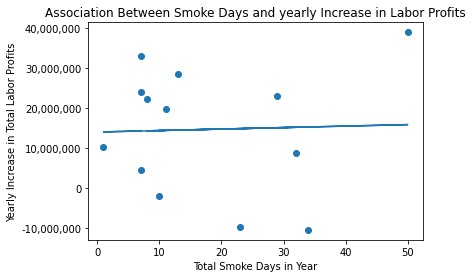

In [32]:
#This cell plots the yearly increase in wildfires in specific years versus the number of smoke days in Clovis for that year

plt.scatter(smoke_days_vs_trendline_changeRates['smoke_days'], smoke_days_vs_trendline_changeRates['rate_of_change_pr'])

z = np.polyfit(smoke_days_vs_trendline_changeRates['smoke_days'], smoke_days_vs_trendline_changeRates['rate_of_change_pr'], 1)
p = np.poly1d(z)
plt.plot(smoke_days_vs_trendline_changeRates['smoke_days'], p(smoke_days_vs_trendline_changeRates['smoke_days']))

plt.xlabel('Total Smoke Days in Year')
plt.ylabel('Yearly Increase in Total Labor Profits')
plt.title('Association Between Smoke Days and yearly Increase in Labor Profits')
plt.gcf().axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
plt.savefig(output_folder + 'qwi_rate_change_vs_smokeDays.png', bbox_inches="tight", facecolor='white', transparent=False)
plt.show()

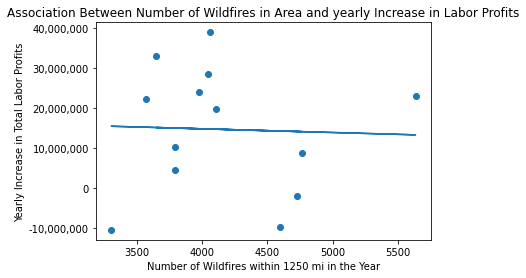

In [33]:
#This cell plots the yearly increase in wildfires in specific years versus the number of in-range wildfires for that year

plt.scatter(smoke_days_vs_trendline_changeRates['num_WF'], smoke_days_vs_trendline_changeRates['rate_of_change_pr'])

z = np.polyfit(smoke_days_vs_trendline_changeRates['num_WF'], smoke_days_vs_trendline_changeRates['rate_of_change_pr'], 1)
p = np.poly1d(z)
plt.plot(smoke_days_vs_trendline_changeRates['num_WF'], p(smoke_days_vs_trendline_changeRates['num_WF']))

plt.title('Association Between Number of Wildfires in Area and yearly Increase in Labor Profits')
plt.xlabel('Number of Wildfires within 1250 mi in the Year')
plt.ylabel('Yearly Increase in Total Labor Profits')
plt.gcf().axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
plt.savefig(output_folder + 'qwi_rate_change_vs_num_WF.png', bbox_inches="tight", facecolor='white', transparent=False)
plt.show()

In [34]:
smoke_days_vs_trendline_changeRates.to_csv(processed_input_data_folder + "smoke_days_vs_trendline_changeRates.csv",
                                          index = False)

## Section 3 - Overall QWI vs. Wildfire Smoke for Workers >=65 yrs

After Section 2 did not find a meaningful relationship between wildfire smoke and labor profits for Clovis, I repeated the same methodology as in that section but using the QWI data for only workers who are 65 years old or older. This is meant to test whether a relationship becomes more defined as we single out groups that are especially vulnerable to the health effects of wildfire smoke. 

The structure of the cells is generally the same as in section 2, except for taking in QWI data that is stratified by Age group and filtering for only the oldest workers (<=65 years).

In [35]:
qwi_data_by_agegroup = pd.read_csv(processed_input_data_folder + "curry_qwi_agegrp_county_quarterly.csv")

qwi_data_by_agegroup = qwi_data_by_agegroup[qwi_data_by_agegroup['agegrp'] == "A08"]

payroll_per_year_65_plus = qwi_data_by_agegroup.groupby('rfrnc_yr')['qwi_payroll'].sum()
payroll_per_year_65_plus = pd.DataFrame({
    "year": list(payroll_per_year_65_plus.index),
    "total_payroll": list(payroll_per_year_65_plus)
})

payroll_per_year_65_plus = payroll_per_year_65_plus[payroll_per_year_65_plus['year'] > 1995]
payroll_per_year_65_plus = payroll_per_year_65_plus[payroll_per_year_65_plus['year'] < 2020]


In [36]:
payroll_rate_of_change = payroll_per_year_65_plus
payroll_rate_of_change['last_year_payroll'] = payroll_per_year_65_plus['total_payroll'].shift(1)
payroll_rate_of_change['payroll_increase'] = payroll_rate_of_change['total_payroll'] - payroll_rate_of_change['last_year_payroll']

In [37]:
changeRates_after_2007 = pd.DataFrame(payroll_rate_of_change[payroll_rate_of_change['year'] > 2006])
changeRates_after_2007.reset_index(inplace = True)


numWF_after_2007 = pd.DataFrame(group_by_year[group_by_year['year'] > 2006])
numWF_after_2007 = pd.DataFrame(numWF_after_2007[numWF_after_2007['year'] < 2020])
numWF_after_2007.reset_index(inplace = True)

smoke_days_vs_trendline_changeRates = pd.DataFrame({
    "year": smoke_days_per_year['year'],
    "smoke_days": smoke_days_per_year['smoke_days'],
    "num_WF": numWF_after_2007['number_of_wildfires'],
    "payroll": changeRates_after_2007['total_payroll'],
    "rate_of_change_pr": changeRates_after_2007['payroll_increase']

})

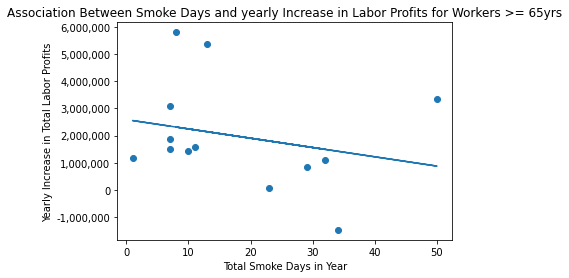

In [38]:
plt.scatter(smoke_days_vs_trendline_changeRates['smoke_days'], smoke_days_vs_trendline_changeRates['rate_of_change_pr'])

z = np.polyfit(smoke_days_vs_trendline_changeRates['smoke_days'], smoke_days_vs_trendline_changeRates['rate_of_change_pr'], 1)
p = np.poly1d(z)
plt.plot(smoke_days_vs_trendline_changeRates['smoke_days'], p(smoke_days_vs_trendline_changeRates['smoke_days']))

plt.xlabel('Total Smoke Days in Year')
plt.ylabel('Yearly Increase in Total Labor Profits')
plt.title('Association Between Smoke Days and yearly Increase in Labor Profits for Workers >= 65yrs')
plt.gcf().axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
plt.savefig(output_folder + '65_plus_qwi_rate_change_vs_smokeDays.png', bbox_inches="tight", facecolor='white', transparent=False)
plt.show()

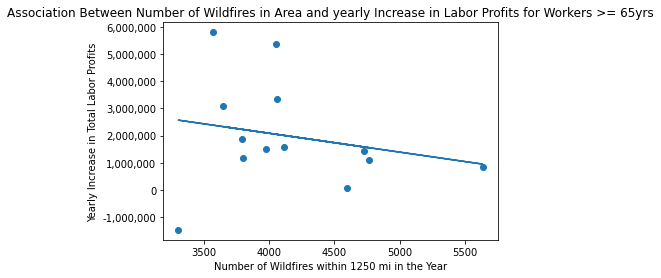

In [39]:
plt.scatter(smoke_days_vs_trendline_changeRates['num_WF'], smoke_days_vs_trendline_changeRates['rate_of_change_pr'])

z = np.polyfit(smoke_days_vs_trendline_changeRates['num_WF'], smoke_days_vs_trendline_changeRates['rate_of_change_pr'], 1)
p = np.poly1d(z)
plt.plot(smoke_days_vs_trendline_changeRates['num_WF'], p(smoke_days_vs_trendline_changeRates['num_WF']))

plt.title('Association Between Number of Wildfires in Area and yearly Increase in Labor Profits for Workers >= 65yrs')
plt.xlabel('Number of Wildfires within 1250 mi in the Year')
plt.ylabel('Yearly Increase in Total Labor Profits')
plt.gcf().axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
plt.savefig(output_folder + '65_plus_qwi_rate_change_vs_num_WF.png', bbox_inches="tight", facecolor='white', transparent=False)
plt.show()

In [40]:
smoke_days_vs_trendline_changeRates.to_csv(processed_input_data_folder + "65_plus_smoke_days_vs_trendline_changeRates.csv",
                                          index = False)